In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path = "../data/componentes"

with open(f'{path}/autovectores_2dpca_2.csv', 'r') as f:
    autovalores_completos = np.array([float(x) for x in f.readline().split()])
    autovectores_completos = np.array([np.array([float(x) for x in line.split()]) for line in f.readlines()])

with open(f'{path}/autovectores_2dpca_sin_uno.csv', 'r') as f:
    autovalores_incompletos = np.array([float(x) for x in f.readline().split()])
    autovectores_incompletos = np.array([np.array([float(x) for x in line.split()]) for line in f.readlines()])

lists = []
with open(f'{path}/media_desviacion_pca_2.txt', 'r') as f:
    array_string = ""
    for line in f:
        stripped_line = line.strip()
        if stripped_line.startswith('['):
            array_string += stripped_line[1:] + " "
        elif stripped_line.endswith(']'):
            array = np.fromstring(array_string, sep=' ')
            lists.append(array.tolist())
            array_string = ""
        else:
            array_string += stripped_line + " "

mean = np.array(lists[0] + [0.16, 0.16])
sd = np.array(lists[1] + [0.16, 0.16])

In [17]:
def imagen_a_componentes_completos(imagenes, k):
    coordenadas_componentes = []

    for imagen in imagenes:
        # La coordenada i-esima es el feature vector i de la imagen
        imagen_estandarizada = ((imagen - mean) / sd).reshape(56, 46)
        coordenadas = np.array([imagen_estandarizada @ autovectores_completos[i] for i in range(k)])

        coordenadas_componentes.append(coordenadas)

    return coordenadas_componentes

def componentes_a_imagen_completos(componentes):
    imagen = np.zeros(shape=(56, 46))

    for i in range(len(componentes)):
        imagen += np.array(componentes[i]).reshape(-1, 1) @ autovectores_completos[i].reshape(-1, 1).T

    return imagen * sd.reshape(56, 46) + mean.reshape(56, 46)

def imagen_a_componentes_incompletos(imagenes, k):
    coordenadas_componentes = []

    for imagen in imagenes:
        # La coordenada i-esima es el feature vector i de la imagen
        imagen_estandarizada = ((imagen - mean) / sd).reshape(56, 46)
        coordenadas = np.array([imagen_estandarizada @ autovectores_incompletos[i] for i in range(k)])

        coordenadas_componentes.append(coordenadas)

    return coordenadas_componentes

def componentes_a_imagen_incompletos(componentes):
    imagen = np.zeros(shape=(56, 46))

    for i in range(len(componentes)):
        imagen += np.array(componentes[i]).reshape(-1, 1) @ autovectores_incompletos[i].reshape(-1, 1).T

    return imagen * sd.reshape(56, 46) + mean.reshape(56, 46) 

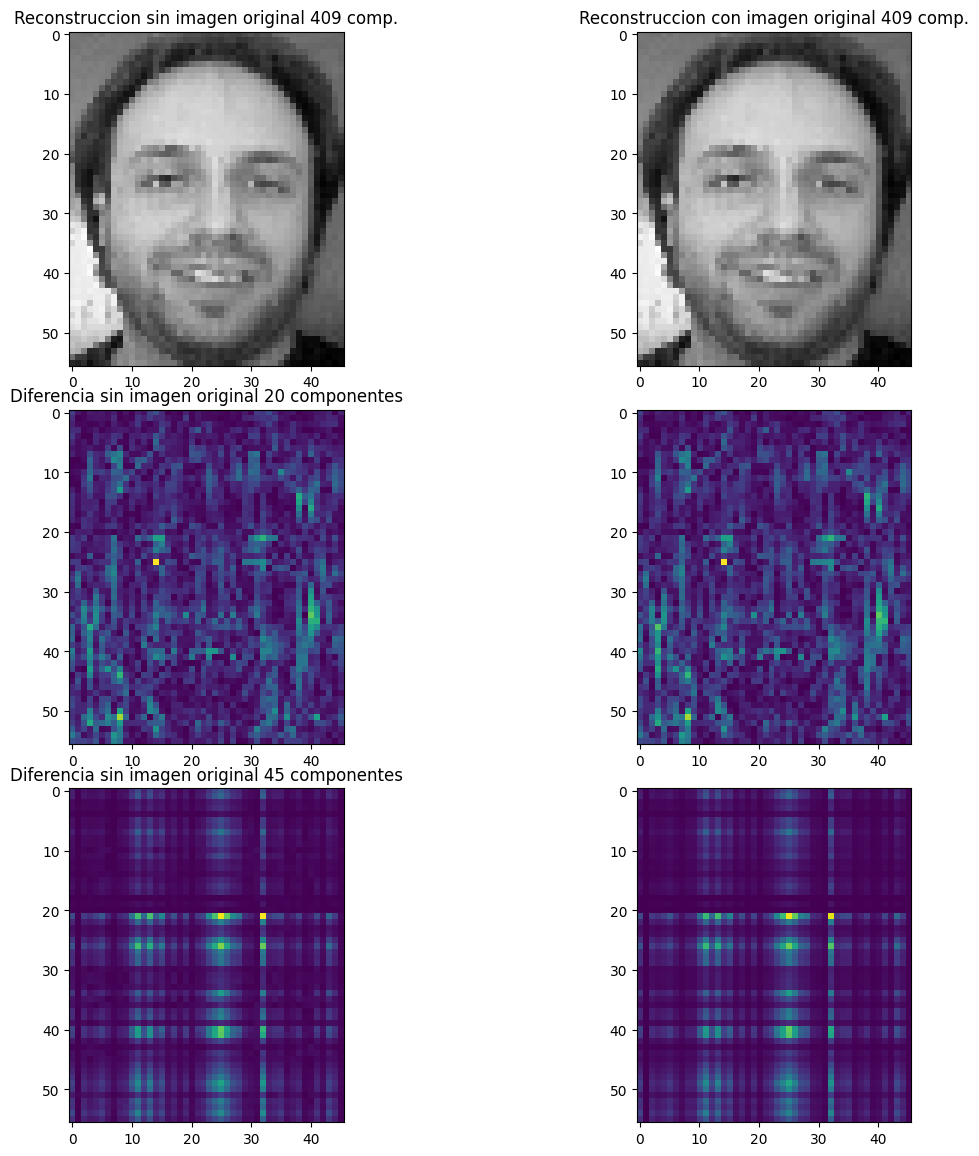

In [19]:
def load_imagen(indice_persona, indice_imagen):
    matriz_imagen = plt.imread(f"../data/caras/s{indice_persona}/{indice_imagen}.pgm")[::2, ::2] / 255
    return matriz_imagen.flatten()

def error_compresion(reconstruida, original):
    return np.abs(reconstruida.flatten() - original.flatten())

imagen_wachin = load_imagen(1, 1)

rango_k = [20, 45]

f, axarr = plt.subplots(3, 2, figsize=(11.5, 11.5))

f.tight_layout()

imagen_reconstruida_completa = componentes_a_imagen_completos(imagen_a_componentes_completos([imagen_wachin], rango_k[1])[0])
imagen_reconstruida_incompleta = componentes_a_imagen_incompletos(imagen_a_componentes_incompletos([imagen_wachin], rango_k[1])[0])

axarr[0, 0].imshow(imagen_reconstruida_incompleta, cmap='gray')
axarr[0, 0].title.set_text(f'Reconstruccion sin imagen original 46 comp')

axarr[0, 1].imshow(imagen_reconstruida_completa, cmap='gray')
axarr[0, 1].title.set_text(f'Reconstruccion con imagen original 46 comp.')

for i in range(len(rango_k)):    
    imagen_reconstruida_completa = componentes_a_imagen_completos(imagen_a_componentes_completos([imagen_wachin], rango_k[i])[0])
    imagen_reconstruida_incompleta = componentes_a_imagen_incompletos(imagen_a_componentes_incompletos([imagen_wachin], rango_k[i])[0])

    error_incompleto = error_compresion(imagen_reconstruida_incompleta, imagen_wachin)
    error_completo = error_compresion(imagen_reconstruida_completa, imagen_wachin)

    _max = max(max(error_incompleto), max(error_completo))
    _min = min(min(error_incompleto), min(error_completo))

    axarr[i + 1, 0].imshow(error_incompleto.reshape(56, 46), vmin = _min, vmax = _max)
    axarr[i + 1, 0].title.set_text(f'Diferencia sin imagen original {rango_k[i]} componentes')

    axarr[i + 1, 1].imshow(error_completo.reshape(56, 46), vmin = _min, vmax = _max)
    axarr[i + 1, 0].title.set_text(f'Diferencia con imagen original {rango_k[i]} componentes')


plt.savefig('graficos')